$$
\begin{array}{c}
\hline
\\
\mathbf{\text{Programming Assignment 3}} \\
\\
\hline
\end{array}
$$

$$
\mathbf{\text{Wonjun Park}} \\
\text{Computer Science and Engineering} \\
\text{University of Texas at Arlington} \\
\text{Arlington, TX, USA} \\
\text{wxp7177@mavs.uta.edu}
$$

***Abstract*** \

### I. INTRODUCTION

### II. LITERATURE REVIEW

#### A. K-Means++

#### B. JAX

### III. METHODOLOGY

### IV. EXPERIMENT

### V. CONCLUSION

### References

In [17]:
import matplotlib.pyplot as plt

In [19]:
!python p3

plt.show()

/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
8794.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


For k = 2 After 9 iterations: SSE = 4545746.0
For k = 3 After 15 iterations: SSE = 2633555.25
For k = 4 After 8 iterations: SSE = 1342208.625
For k = 5 After 4 iterations: SSE = 916379.25
For k = 6 After 8 iterations: SSE = 707939.8125
For k = 7 After 11 iterations: SSE = 414752.875
For k = 8 After 9 iterations: SSE = 388114.0625
Figure(640x480)


Based on the Elbow method, the most good value of $K$ is 

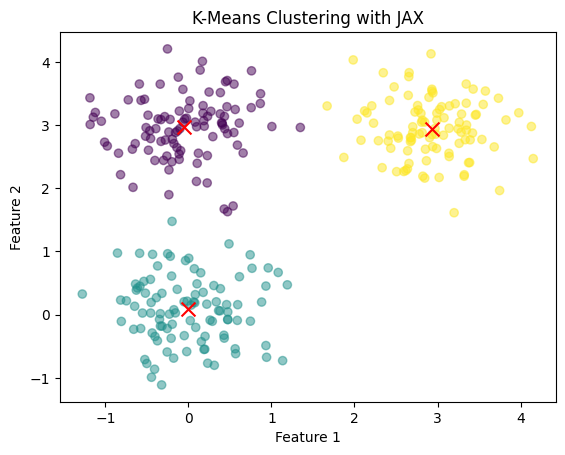

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


def init_centroids(X, k, key):
    idx = jax.random.choice(key, X.shape[0], shape=(k,), replace=False)
    centroids = X[idx]
    return centroids


def compute_distances(X, centroids):
    # X: (n_samples, n_features)
    # centroids: (k, n_features)
    # Returns: (n_samples, k)
    distances = jnp.sum((X[:, None, :] - centroids[None, :, :]) ** 2, axis=2)
    return distances


def assign_clusters(distances):
    # distances: (n_samples, k)
    # Returns: (n_samples,)
    return jnp.argmin(distances, axis=1)


def compute_new_centroids(X, labels, k):
    # X: (n_samples, n_features)
    # labels: (n_samples,)
    # Returns: (k, n_features)
    centroids_sum = jax.ops.segment_sum(X, labels, num_segments=k)
    counts = jnp.bincount(labels, minlength=k).reshape(-1, 1)
    # Handle division by zero in case a cluster has no points assigned
    counts = jnp.where(counts == 0, 1, counts)
    centroids = centroids_sum / counts
    return centroids


def kmeans(X, k, num_iters=100, key=jax.random.PRNGKey(0)):
    centroids = init_centroids(X, k, key)

    for i in range(num_iters):
        distances = compute_distances(X, centroids)
        labels = assign_clusters(distances)
        new_centroids = compute_new_centroids(X, labels, k)

        # Check for convergence
        if jnp.allclose(centroids, new_centroids, atol=1e-6):
            break
        centroids = new_centroids
    return centroids, labels


# Generate sample data
np.random.seed(0)
X_np = np.vstack(
    [
        np.random.normal(loc=(0, 0), scale=0.5, size=(100, 2)),
        np.random.normal(loc=(3, 3), scale=0.5, size=(100, 2)),
        np.random.normal(loc=(0, 3), scale=0.5, size=(100, 2)),
    ]
)

# Convert to JAX array
X = jnp.array(X_np)

# Run K-Means
k = 3
key = jax.random.PRNGKey(42)
centroids, labels = kmeans(X, k, num_iters=100, key=key)

# Convert JAX arrays to NumPy arrays for plotting
X_plot = np.array(X)
labels_plot = np.array(labels)
centroids_plot = np.array(centroids)

plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels_plot, cmap="viridis", alpha=0.5)
plt.scatter(centroids_plot[:, 0], centroids_plot[:, 1], c="red", marker="x", s=100)
plt.title("K-Means Clustering with JAX")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

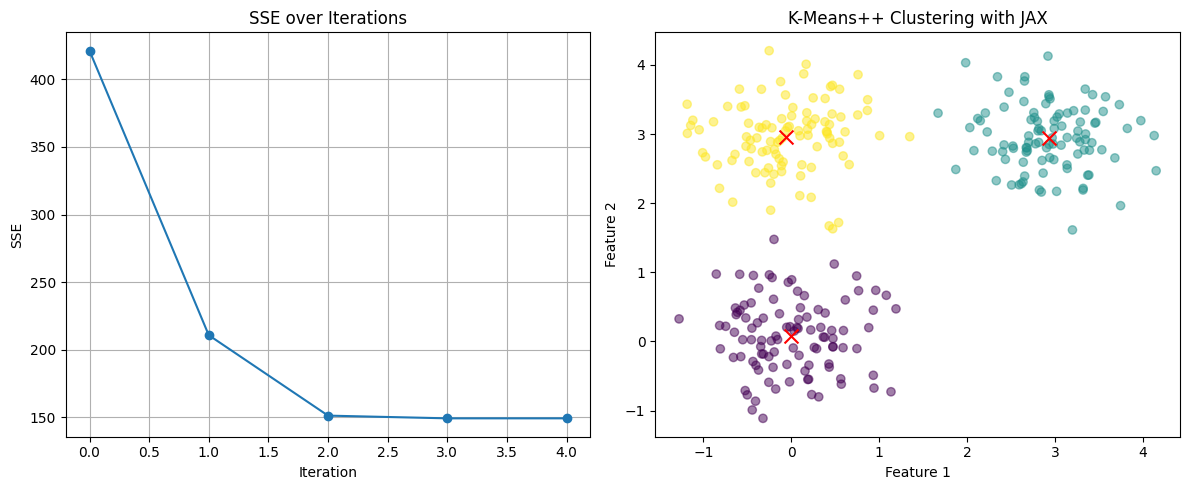

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Existing functions (compute_distances, assign_clusters, compute_new_centroids, compute_sse) remain the same

def compute_distances(X, centroids):
    distances = jnp.sum((X[:, None, :] - centroids[None, :, :]) ** 2, axis=2)
    return distances

def assign_clusters(distances):
    return jnp.argmin(distances, axis=1)

def compute_new_centroids(X, labels, k):
    centroids_sum = jax.ops.segment_sum(X, labels, num_segments=k)
    counts = jnp.bincount(labels, minlength=k).reshape(-1, 1)
    counts = jnp.where(counts == 0, 1, counts)
    centroids = centroids_sum / counts
    return centroids

def compute_sse(X, centroids, labels):
    assigned_centroids = centroids[labels]
    errors = X - assigned_centroids
    squared_errors = jnp.sum(errors ** 2, axis=1)
    sse = jnp.sum(squared_errors)
    return sse

def weighted_choice(key, a, p):
    cumulative_probs = jnp.cumsum(p)
    r = jax.random.uniform(key, ()) * cumulative_probs[-1]
    idx = jnp.searchsorted(cumulative_probs, r, side="right")
    return a[idx]

def init_centroids_kmeans_plusplus(X, k, key):
    n_samples = X.shape[0]
    keys = jax.random.split(key, k)
    
    # Choose the first centroid randomly
    idx = jax.random.randint(keys[0], (), 0, n_samples)
    centroids = [X[idx]]
    
    for i in range(1, k):
        # Compute distances from data points to the nearest centroid
        distances = jnp.min(
            jnp.stack([jnp.sum((X - c) ** 2, axis=1) for c in centroids], axis=1),
            axis=1
        )
        # Compute probabilities proportional to squared distances
        total_distance = jnp.sum(distances)
        probabilities = distances / total_distance

        # Sample next centroid with the computed probabilities
        idx = weighted_choice(keys[i], jnp.arange(n_samples), probabilities)
        centroids.append(X[idx])j

    return jnp.array(centroids)

def kmeans(X, k, num_iters=100, key=jax.random.PRNGKey(0)):
    centroids = init_centroids_kmeans_plusplus(X, k, key)
    sse_history = []
    
    for i in range(num_iters):
        distances = compute_distances(X, centroids)
        labels = assign_clusters(distances)
        new_centroids = compute_new_centroids(X, labels, k)
        
        # Compute SSE
        sse = compute_sse(X, new_centroids, labels)
        sse_history.append(sse)

        # Check for convergence
        if jnp.allclose(centroids, new_centroids, atol=1e-6):
            break
        centroids = new_centroids

    sse_history = jnp.array(sse_history)
    return centroids, labels, sse_history

# Generate sample data
np.random.seed(0)
X_np = np.vstack([
    np.random.normal(loc=(0, 0), scale=0.5, size=(100, 2)),
    np.random.normal(loc=(3, 3), scale=0.5, size=(100, 2)),
    np.random.normal(loc=(0, 3), scale=0.5, size=(100, 2))
])

X = jnp.array(X_np)

# Run K-Means with K-Means++ initialization
k = 3
key = jax.random.PRNGKey(42)
centroids, labels, sse_history = kmeans(X, k, num_iters=100, key=key)

# Plot SSE over iterations
sse_history_plot = np.array(sse_history)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(sse_history_plot)), sse_history_plot, marker='o')
plt.title('SSE over Iterations')
plt.xlabel('Iteration')
plt.ylabel('SSE')
plt.grid(True)

# Plot the clustered data
X_plot = np.array(X)
labels_plot = np.array(labels)
centroids_plot = np.array(centroids)

plt.subplot(1, 2, 2)
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels_plot, cmap='viridis', alpha=0.5)
plt.scatter(centroids_plot[:, 0], centroids_plot[:, 1], c='red', marker='x', s=100)
plt.title('K-Means++ Clustering with JAX')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()
